Implemented By Muhammad Hanan Asghar.
Github: https://github.com/MuhammadHananAsghar

In [ ]:
!unzip "/content/data_face_classification_recognition.zip"

In [ ]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
batch_size = 18
img_height = 70
img_width = 70

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 5 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/valid",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 914 files belonging to 5 classes.


In [ ]:
class_names = train_ds.class_names
num_classes =len(class_names)
print(class_names)

['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']


In [ ]:
num_classes

5

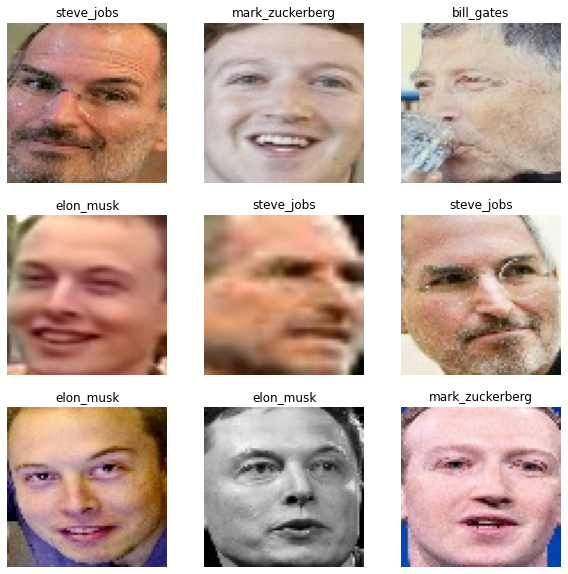

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model_face_classification.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/100
167/167 [==============================] - 2s 7ms/step - loss: 1.5791 - accuracy: 0.2590 - val_loss: 1.3827 - val_accuracy: 0.4234

Epoch 00001: val_loss improved from inf to 1.38265, saving model to model_face_classification.h5
Epoch 2/100
167/167 [==============================] - 1s 6ms/step - loss: 1.2089 - accuracy: 0.5183 - val_loss: 0.7102 - val_accuracy: 0.7560

Epoch 00002: val_loss improved from 1.38265 to 0.71022, saving model to model_face_classification.h5
Epoch 3/100
167/167 [==============================] - 1s 6ms/step - loss: 0.6984 - accuracy: 0.7437 - val_loss: 0.3393 - val_accuracy: 0.8906

Epoch 00003: val_loss improved from 0.71022 to 0.33930, saving model to model_face_classification.h5
Epoch 4/100
167/167 [==============================] - 1s 6ms/step - loss: 0.5123 - accuracy: 0.8170 - val_loss: 0.2937 - val_accuracy: 0.8775

Epoch 00004: val_loss improved from 0.33930 to 0.29375, saving model to model_face_classification.h5
Epoch 5/100
167/167 [===

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

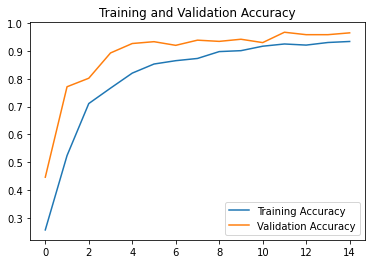

In [ ]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

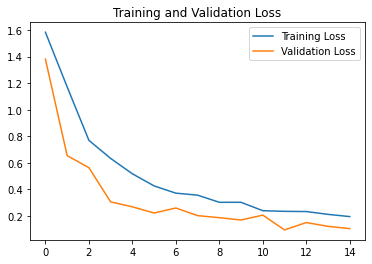

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Predicting

In [ ]:
!pip install facenet_pytorch

In [ ]:
import numpy as np
# from facenet_pytorch import MTCNN
import cv2

In [ ]:
!pip install mtcnn

In [ ]:
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import cv2

In [ ]:
detector = MTCNN()

In [ ]:
def get_face(image):
    detector = MTCNN()
    imge = plt.imread(image)
    boxes = detector.detect_faces(imge)
    boxes = boxes[0]['box']
    boxes = [int(i) for i in boxes]
    return boxes, imge

In [ ]:
model = keras.models.load_model("/content/model_face_classification.h5")

In [ ]:
bbox, sample_image = get_face("/content/steve_jobs_test.jpg")
class_names = ['bill_gates', 'elon_musk', 'jeff_bezos', 'mark_zuckerberg', 'steve_jobs']
x1, y1, width, height = bbox
x2, y2 = x1 + width, y1 + height
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))

img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)
model = keras.models.load_model("model_face_classification.h5", compile=False)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
predicted = class_names[np.argmax(score)]
percentage = round(100 * np.max(score), 2)

In [ ]:
print(predicted, percentage)

steve_jobs 99.99


In [ ]:
img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

In [ ]:
score

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.0019092e-04, 3.9339279e-06, 2.3953669e-07, 1.0924160e-05,
       9.9988472e-01], dtype=float32)>

In [ ]:
round(100 * np.max(score), 2)

99.99

In [ ]:
boxes = boxes[0]['box']
print(boxes)

[481, 234, 585, 730]


In [ ]:
x1, y1, x2, y2 = boxes
face_image = imge[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

In [ ]:
mtcnn = MTCNN()

def get_face(image):
  imge = plt.imread(image)
  boxes, probs, landmarks = mtcnn.detect(imge, landmarks=True)
  boxes = boxes[0]
  boxes = [int(i) for i in boxes]
  return boxes, imge

In [ ]:
image_path = "/content/Jeff_Bezos_test.jpg"
bbox, sample_image = get_face(image_path)
x1, y1, x2, y2 = bbox
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

plt.imshow(face_image)

AttributeError: ignored

This image most likely belongs to steve_jobs with a 99.95 percent confidence.


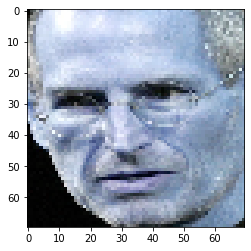

In [ ]:
image_path = "/content/steve_jobs_test.jpg"
bbox, sample_image = get_face(image_path)
x1, y1, x2, y2 = bbox
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
plt.imshow(face_image)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to bill_gates with a 99.95 percent confidence.


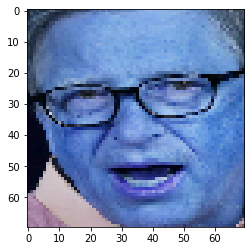

In [ ]:
image_path = "/content/bill_gates_test.jpg"
bbox, sample_image = get_face(image_path)
x1, y1, x2, y2 = bbox
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
plt.imshow(face_image)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to jeff_bezos with a 92.37 percent confidence.


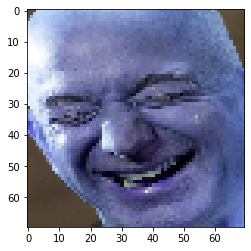

In [ ]:
image_path = "/content/Jeff_Bezos_test.jpg"
bbox, sample_image = get_face(image_path)
x1, y1, x2, y2 = bbox
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
plt.imshow(face_image)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to mark_zuckerberg with a 42.75 percent confidence.


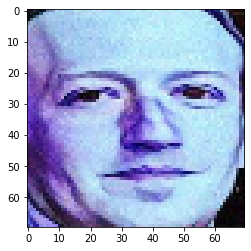

In [ ]:
image_path = "/content/mark_zuckerberg_test.jpg"
bbox, sample_image = get_face(image_path)
x1, y1, x2, y2 = bbox
face_image = sample_image[y1:y2, x1:x2]
face_image = cv2.resize(face_image, (70, 70))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)

img_array = keras.preprocessing.image.img_to_array(face_image)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
plt.imshow(face_image)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)